# Roman configurations

In [25]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import os
import slsim
import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
from slsim.Plots.lens_plots import LensingPlots
from slsim.lens_pop import LensPop

%matplotlib inline

In [26]:
# Import default Roman Space Telescope configuration
# path = os.path.dirname(slsim.__file__)
# module_path, _ = os.path.split(path)
# skypy_config = os.path.join(module_path, "data/SkyPy/roman-like.yml")

import mejiro

module_path = os.path.dirname(mejiro.__file__)
skypy_config = os.path.join(module_path, 'data', 'roman_hlwas.yml')

In [27]:
# # generate Roman filters
# configure_roman_filters()

# # import filter bands and make them recogniable in speclite
# roman_filters = filter_names()
# # filters are ['Roman-F062', 'Roman-F087', 'Roman-F106', 'Roman-F129', 'Roman-F158', 'Roman-F184', 'Roman-F146', 'Roman-F213']

# speclite.filters.load_filters(
#     roman_filters[0],
#     roman_filters[1],
#     roman_filters[2],
#     roman_filters[3],
#     roman_filters[4],
#     roman_filters[5],
#     roman_filters[6],
#     roman_filters[7],
# )

In [28]:
configure_roman_filters()
roman_filters = filter_names()
roman_filters.sort()
# roman_filters = sorted(glob(os.path.join(repo_dir, 'mejiro', 'data', 'avg_filter_responses', 'Roman-*.ecsv')))
_ = speclite.filters.load_filters(*roman_filters[:8])
print('Configured Roman filters. Loaded:')
print(roman_filters[:8])

Configured Roman filters. Loaded:
['/home/btwedig/slsim/data/Filters/Roman/Roman-F062.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F087.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F106.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F129.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F146.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F158.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F184.ecsv', '/home/btwedig/slsim/data/Filters/Roman/Roman-F213.ecsv']


In [30]:
from astropy.cosmology import default_cosmology

# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# cosmo = default_cosmology.get()

# define a sky area
sky_area = Quantity(value=0.5, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F062", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class
lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=skypy_config,
    sky_area=sky_area,
    cosmo=cosmo,
)

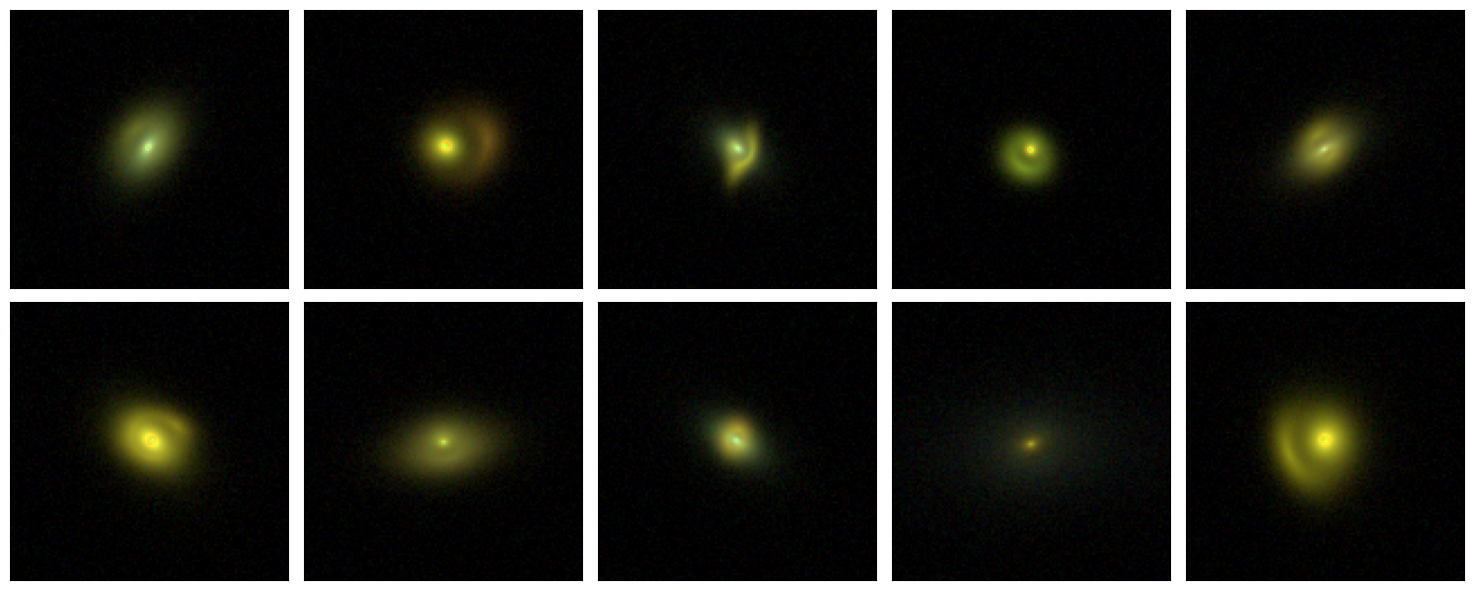

In [31]:
kwargs_lens_cut_plot = {
    "min_image_separation": 0.5,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 21, "F106": 21, "F062": 21},
}

# make montage of realizations
gg_plot = LensingPlots(lens_pop, num_pix=124, observatory="Roman")

fig, axes = gg_plot.plot_montage(
    rgb_band_list=["F184", "F129", "F062"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()

In [32]:
kwargs_lens_cut = {
    "min_image_separation": 0.1,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 25, "F062": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

In [33]:
print("Number of lenses:", len(lens_population))
print(f'Number of lenses per square degree: {len(lens_population) / sky_area.value:.2f}')

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 5509
Number of lenses per square degree: 11018.00


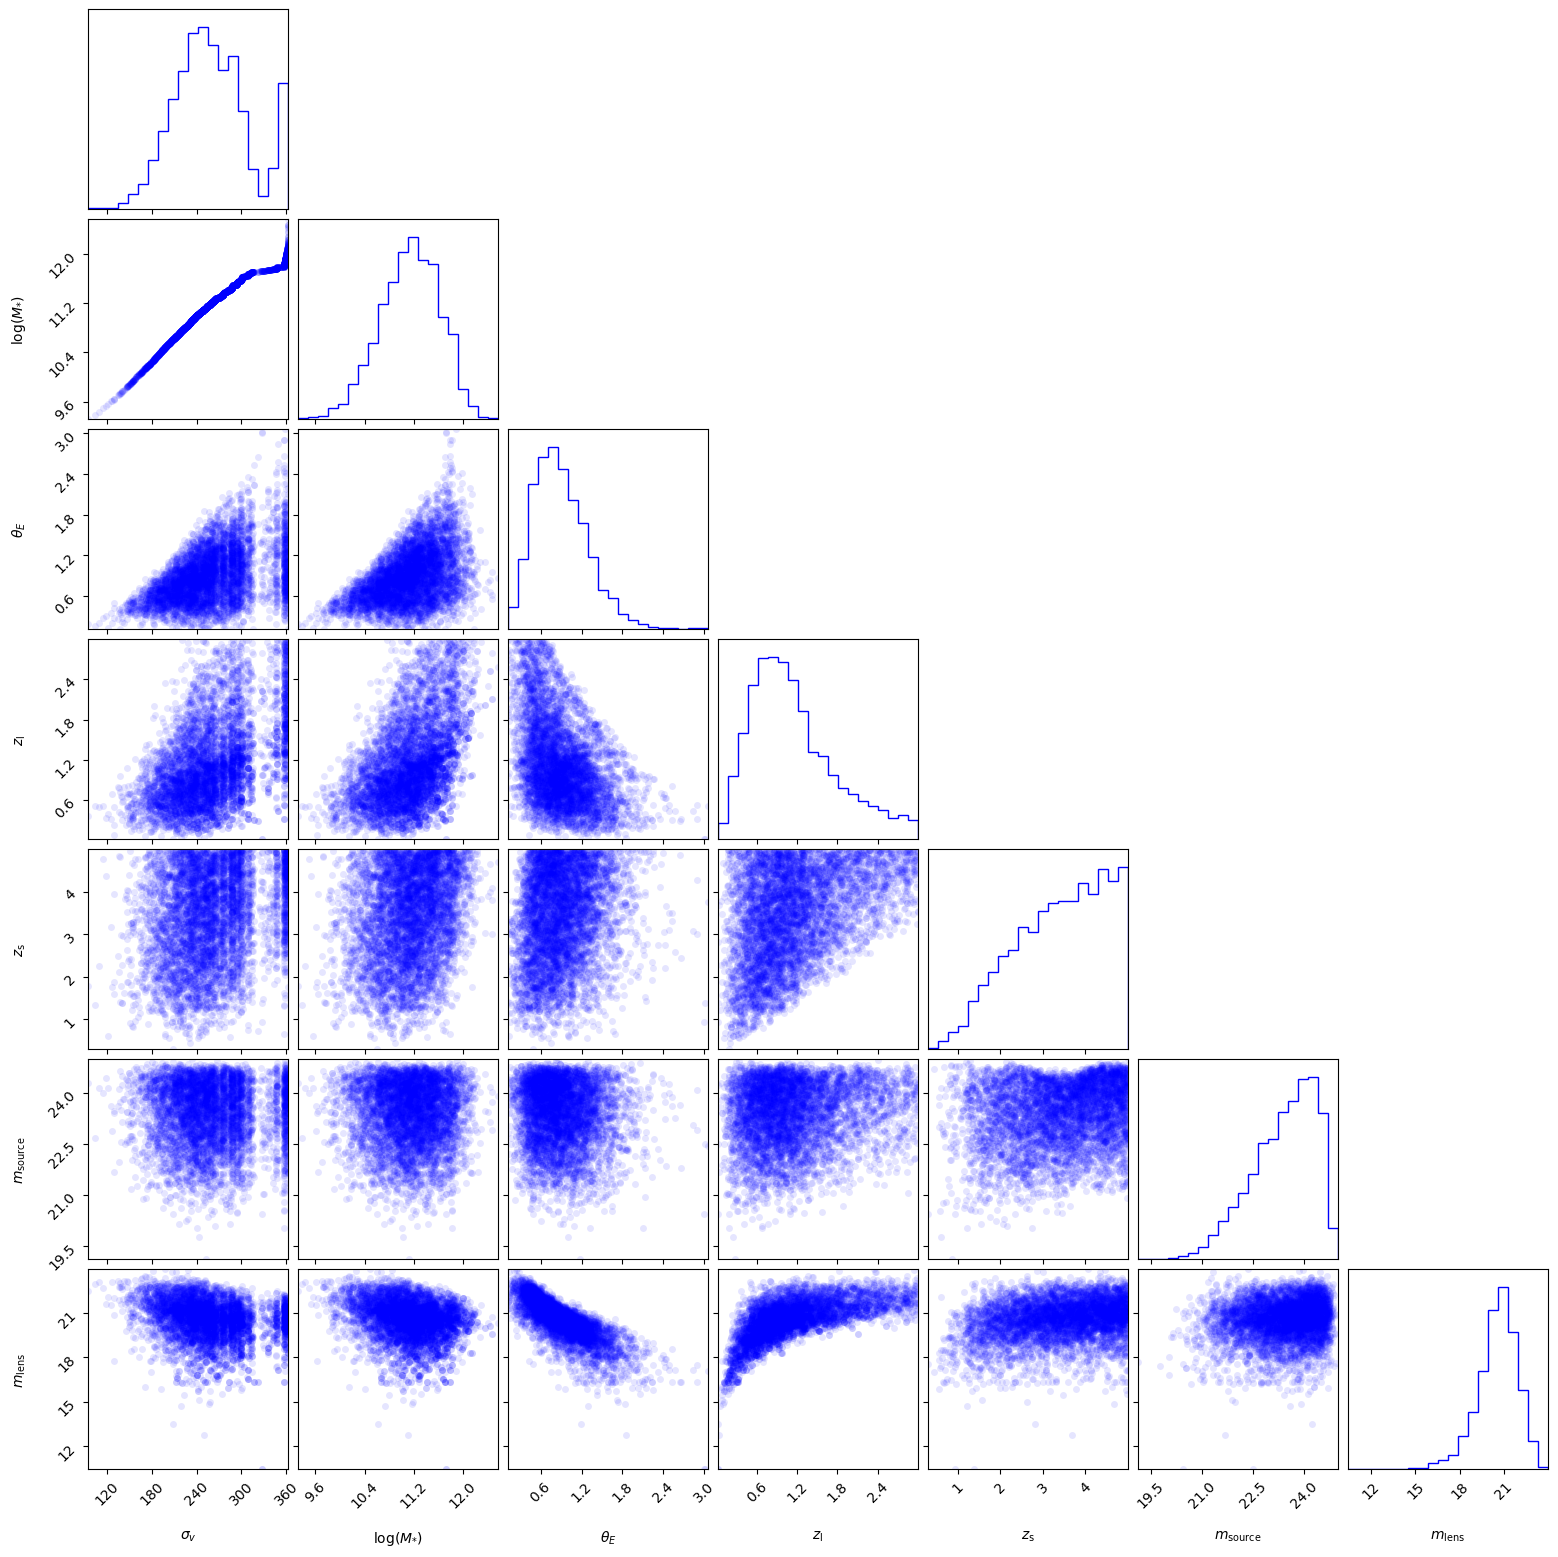

In [34]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()